<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/070523_Rumor_Basic_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    # kmax = int(((gamma-1)/(gamma-2) * n )** (1/gamma))  # max degree
    # Example: kmax = int(1.5*n**(1/4)) # gamma=4: 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [4]:
def generate_configuration_model(degree_sequence):
    # Create an empty graph and sum up the degrees
    G = nx.Graph()
    degree_sum = sum(degree_sequence)

    # Print error message if the sum is odd
    if degree_sum % 2 != 0:
        raise ValueError("Degree sum is odd")

    # Create a list of nodes based on the degree sequence
    nodes = []
    for node, degree in enumerate(degree_sequence):
        nodes.extend([node] * degree)

    # Shuffle the nodes list
    random.shuffle(nodes)

    # Track visited edges
    existing_edges = set()

    # Pair the nodes and add edges to the graph
    for i in range(0, len(nodes), 2):
        node1 = nodes[i]
        node2 = nodes[i + 1]

        # Check for self-edges and duplicate edges
        if node1 != node2 and (node1, node2) not in existing_edges:
            G.add_edge(node1, node2)
            existing_edges.add((node1, node2))
            existing_edges.add((node2, node1))

    return G

In [7]:
## The following is the baseline rumor model
## There are 3 states: S(ignorant), I(spreader), R(stifler)

def Rumor_Basic(nw, lam, alp, n_samp):
   # initialize variables
    t_max = 10000
    N = len(nw.nodes)
    degrees = dict(nw.degree())
    kmax = max(degrees.values())
    t_end = np.zeros(n_samp+1)
    rho_R_end = np.zeros(n_samp+1)

    for i_samp in range(1, n_samp+1):
        t = 0
        rho_R = 0
        N_rec = 0

        # Initialize states with ignorant individuals
        states = {j: 0 for j in nw.nodes()}

        # Randomly select an initial spreader node
        inf = []
        initial_node = np.random.choice(list(nw.nodes()))
        states[initial_node] = 1
        inf.append(initial_node)
        N_inf = 1
        N_e = nw.degree(initial_node)

        # Use exponential distribution for non-fixed time steps
        while t < t_max and N_inf > 0:
            total_rate = lam * N_e + 2 * alp * N_e
            #total_rate = lam * N_e + alp * N_e
            tau = -np.log(np.random.uniform(1e-6,1))/total_rate
            t += tau

            # Select a spreader individual to start an event
            node = np.random.choice(inf)
            # Determine if selected spreader is accepted based on degree distribution
            q_deg = np.random.uniform(0,1)
            if q_deg > degrees[node]/kmax:
                neighbors = list(nw.neighbors(node))
                neighbor = np.random.choice(neighbors)
                # Determine which event occurs
                event = np.random.uniform(0,1)
                p1 = lam / (lam + alp)
                p2 = alp / (lam + alp)

                # Update ignorant neighbor to spreader
                if states[neighbor] == 0:
                    # Infection event: I + S --> 2I
                    if event < p1:
                        states[neighbor] = 1
                        inf.append(neighbor)
                        N_inf += 1
                        N_e += nw.degree(neighbor)

                else: # if the selected neighbor is a spreader or stifler
                    # Recovery event : I + I --> R + I, I + R --> 2R
                    if event < p2:
                            # Update spreader to stifler
                            states[node] = 2
                            N_e -= nw.degree(node)
                            N_inf -= 1
                            inf.remove(node)
                            rho_R += (1 / N)
                            N_rec += 1

            if N_inf == 0:
                t_end[i_samp] = t
                rho_R_end[i_samp] = rho_R
                print(t, N_rec, rho_R, lam)
        # Reset spreader and stiflers for the next sample
        #for node, state in states.items():
        #    if state == 1 or state == 2:
        #        states[node] = 0

    # Compute the average rho_R and t_end values
    rho_R_av = np.mean(rho_R_end)
    t_end_av = np.mean(t_end)

    return rho_R_av, t_end_av


[6, 3, 4, 3, 4, 4, 4, 3, 3, 10, 3, 4, 3, 3, 3, 6, 3, 4, 4, 3, 3, 3, 10, 5, 3, 4, 3, 6, 3, 10, 4, 3, 4, 7, 5, 4, 3, 5, 4, 3, 5, 3, 12, 3, 8, 5, 3, 3, 3, 8, 7, 3, 3, 3, 4, 3, 4, 3, 8, 4, 3, 3, 3, 6, 3, 3, 4, 3, 11, 5, 3, 5, 3, 4, 3, 4, 3, 5, 3, 6, 24, 6, 3, 3, 3, 6, 4, 6, 3, 3, 3, 5, 3, 4, 3, 5, 3, 4, 7, 3, 3, 13, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 9, 3, 3, 3, 3, 8, 3, 3, 10, 5, 3, 5, 20, 3, 7, 3, 3, 4, 5, 4, 5, 23, 3, 6, 10, 6, 10, 5, 3, 6, 3, 6, 3, 4, 7, 3, 7, 6, 5, 3, 4, 4, 3, 3, 3, 5, 3, 5, 5, 4, 3, 6, 4, 11, 5, 7, 8, 3, 3, 9, 6, 3, 22, 4, 3, 9, 3, 3, 4, 4, 3, 14, 3, 5, 7, 3, 14, 16, 4, 5, 3, 3, 3, 3, 5, 6, 5, 6, 3, 3, 3, 3, 7, 3, 16, 3, 3, 3, 7, 3, 3, 6, 3, 3, 3, 3, 3, 22, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 13, 4, 3, 3, 6, 3, 11, 5, 3, 4, 3, 3, 5, 3, 4, 3, 3, 6, 5, 6, 3, 3, 4, 4, 3, 6, 10, 3, 3, 4, 11, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 6, 3, 6, 4, 3, 3, 5, 20, 3, 6, 3, 7, 3, 3, 3, 3, 3, 4, 3, 9, 3, 6, 4, 3, 4, 4, 18, 3, 3, 3, 4, 3, 5, 6, 12, 3, 3

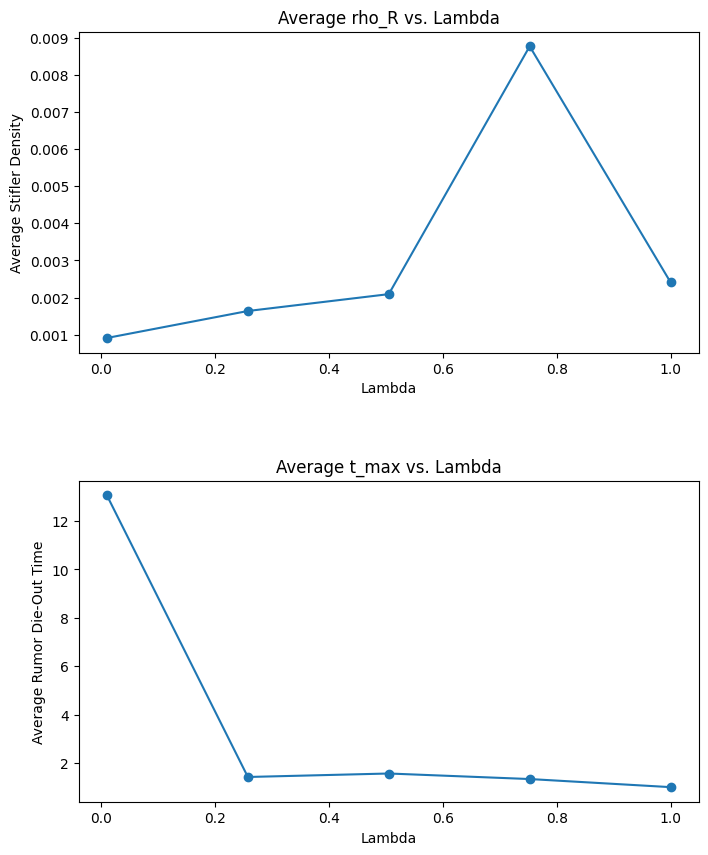

In [18]:
# Test:
n= 2000
gamma = 2.7
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
print(degrees)
nw = generate_configuration_model(degrees)

alp = 1

n_samp = 10

lambda_values = np.linspace(0.01, 1, num=5)  # Generate lambda values from 0 to 1 with 0.05 steps
rho_R_av_values = []
t_end_av_values = []

for lam in lambda_values:
    rho_R_av, t_end_av = Rumor_Basic(nw, lam, alp, n_samp)
    rho_R_av_values.append(rho_R_av)
    t_end_av_values.append(t_end_av)

avg_rho_R_values = np.array(rho_R_av_values)
avg_t_end_values = np.array(t_end_av_values)

# Plot the two-panel graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Top panel: average density of stifler rho_R against spreading rate lambda
ax1.plot(lambda_values, avg_rho_R_values, 'o-')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Average Stifler Density')
ax1.set_title('Average rho_R vs. Lambda')

# Bottom panel: average rumor die-out time t_max against spreading rate lambda
ax2.plot(lambda_values, avg_t_end_values, 'o-')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Average Rumor Die-Out Time')
ax2.set_title('Average t_max vs. Lambda')

plt.subplots_adjust(hspace=0.4)
plt.show()